In [9]:
import sys
import datetime
import matplotlib.pyplot as plt
from pathlib import Path
import pyarrow as pa
import pyarrow.parquet as pq
import os
import pandas as pd
import logging
sys.path.append(r'C:\Users\Administrator\finstral-1')
import qt_api.qt_api as qt
import src.local_symbols as local_symbols
import src.local_candles as local_candles


In [10]:
# Read the list of symbols from the DOWJONES CSV file
symbols_file = "../lists/DOWJONES.csv"
list_name = os.path.basename(symbols_file).split('.')[0]
symbols_list = pd.read_csv(symbols_file, sep=";")

In [11]:
df = local_candles.load_parquet()
df

[WindowsPath('C:/Users/Administrator/finstral-1/data/parquet/20250406_AG_combined.parquet')]
📂 Loading most recent parquet file: 20250406_AG_combined.parquet


interval                  end    open    high  \
item_id timestamp                                                             
BRK.B   2025-01-06 06:15:00  OneMinute  2025-01-06 06:16:00  456.10  456.20   
        2025-01-06 06:21:00  OneMinute  2025-01-06 06:22:00  456.35  456.35   
        2025-01-06 07:00:00  OneMinute  2025-01-06 07:01:00  456.54  456.54   
        2025-01-06 07:59:00  OneMinute  2025-01-06 08:00:00  456.30  456.30   
        2025-01-06 08:00:00  OneMinute  2025-01-06 08:01:00  456.71  456.71   
...                                ...                  ...     ...     ...   
MDB     2025-04-04 18:54:00  OneMinute  2025-04-04 18:55:00  153.95  153.95   
        2025-04-04 19:00:00  OneMinute  2025-04-04 19:01:00  153.51  153.51   
        2025-04-04 19:36:00  OneMinute  2025-04-04 19:37:00  153.51  153.51   
        2025-04-04 19:50:00  OneMinute  2025-04-04 19:51:00  153.50  153.50   
        2025-04-04 19:59:00  OneMinute  2025-04-04 20:00:00  153.50  153.50   

                                low   close  volume        VWAP  \
item_id timestamp                                                 
BRK.B   2025-01-06 06:15:00  456.10  456.20     258  455.882852   
        2025-01-06 06:21:00  456.35  456.35     100  455.961142   
        2025-01-06 07:00:00  456.07  456.07     300  456.179291   
        2025-01-06 07:59:00  456.30  456.30     346  456.208096   
        2025-01-06 08:00:00  456.31  456.31    1484  456.240498   
...                             ...     ...     ...         ...   
MDB     2025-04-04 18:54:00  153.95  153.95     496  156.060306   
        2025-04-04 19:00:00  153.51  153.51     110  156.060191   
        2025-04-04 19:36:00  153.51  153.51     398  156.060250   
        2025-04-04 19:50:00  153.50  153.50     110  156.060318   
        2025-04-04 19:59:00  153.50  153.50     693  156.059773   

                                industrySector  
item_id timestamp                               
BRK.B   2025-01-06 06:15:00  FinancialServices  
        2025-01-06 06:21:00  FinancialServices  
        2025-01-06 07:00:00  FinancialServices  
        2025-01-06 07:59:00  FinancialServices  
        2025-01-06 08:00:00  FinancialServices  
...                                        ...  
MDB     2025-04-04 18:54:00         Technology  
        2025-04-04 19:00:00         Technology  
        2025-04-04 19:36:00         Technology  
        2025-04-04 19:50:00         Technology  
        2025-04-04 19:59:00         Technology  

[15765758 rows x 9 columns]

In [12]:
symbols_list['Symbol']# First, get the list of symbols we want to keep
valid_symbols = symbols_list['Symbol'].tolist()

# Filter the DataFrame to keep only rows where item_id is in valid_symbols
df_filtered = df[df.index.get_level_values('item_id').isin(valid_symbols)]
print(f"List name: {list_name}")
print(f"Original rows: {len(df)}")
print(f"Filtered rows: {len(df_filtered)}")
print(f"\nSymbols kept: {len(df_filtered.index.get_level_values('item_id').unique())}")

List name: DOWJONES
Original rows: 15765758
Filtered rows: 885632

Symbols kept: 30


In [13]:
# Create target column for prediction
# Make a copy of the filtered dataframe to avoid SettingWithCopyWarning
df_filtered = df_filtered.copy()
# Now safely add the target column
df_filtered['target'] = df_filtered['close'].astype(float)


In [14]:
from autogluon.tabular import TabularDataset, TabularPredictor

In [15]:
# Create a signature column based on price movement
# This will be our target for prediction
df_filtered['target'] = (df_filtered['close'] > df_filtered['open']).astype(int)

# Display statistics about our target variable
label = 'target'
df_filtered[label].describe()
df_filtered


interval                  end    open    high  \
item_id timestamp                                                             
GS      2025-01-06 04:31:00  OneMinute  2025-01-06 04:32:00  581.34  581.34   
        2025-01-06 04:46:00  OneMinute  2025-01-06 04:47:00  580.13  580.13   
        2025-01-06 05:05:00  OneMinute  2025-01-06 05:06:00  579.01  579.01   
        2025-01-06 05:06:00  OneMinute  2025-01-06 05:07:00  578.52  578.52   
        2025-01-06 05:07:00  OneMinute  2025-01-06 05:08:00  579.00  579.00   
...                                ...                  ...     ...     ...   
HON     2025-04-04 16:28:00  OneMinute  2025-04-04 16:29:00  190.06  190.06   
        2025-04-04 16:36:00  OneMinute  2025-04-04 16:37:00  190.39  190.39   
        2025-04-04 16:45:00  OneMinute  2025-04-04 16:46:00  190.99  190.99   
        2025-04-04 16:46:00  OneMinute  2025-04-04 16:47:00  190.99  190.99   
        2025-04-04 17:43:00  OneMinute  2025-04-04 17:44:00  190.99  190.99   

                                low   close  volume        VWAP  \
item_id timestamp                                                 
GS      2025-01-06 04:31:00  581.34  581.34     100  581.058981   
        2025-01-06 04:46:00  580.13  580.13     110  580.486817   
        2025-01-06 05:05:00  579.01  579.01     100  579.895907   
        2025-01-06 05:06:00  578.52  578.52     100  579.715370   
        2025-01-06 05:07:00  579.00  579.00     101  579.658848   
...                             ...     ...     ...         ...   
HON     2025-04-04 16:28:00  190.06  190.06     388  195.863067   
        2025-04-04 16:36:00  190.39  190.39     300  195.911089   
        2025-04-04 16:45:00  190.99  190.99    1221  195.910294   
        2025-04-04 16:46:00  190.99  190.99     100  195.910235   
        2025-04-04 17:43:00  190.96  190.96     204  195.911073   

                                industrySector  target  
item_id timestamp                                       
GS      2025-01-06 04:31:00  FinancialServices       0  
        2025-01-06 04:46:00  FinancialServices       0  
        2025-01-06 05:05:00  FinancialServices       0  
        2025-01-06 05:06:00  FinancialServices       0  
        2025-01-06 05:07:00  FinancialServices       0  
...                                        ...     ...  
HON     2025-04-04 16:28:00         Industrial       0  
        2025-04-04 16:36:00         Industrial       0  
        2025-04-04 16:45:00         Industrial       0  
        2025-04-04 16:46:00         Industrial       0  
        2025-04-04 17:43:00         Industrial       0  

[885632 rows x 10 columns]

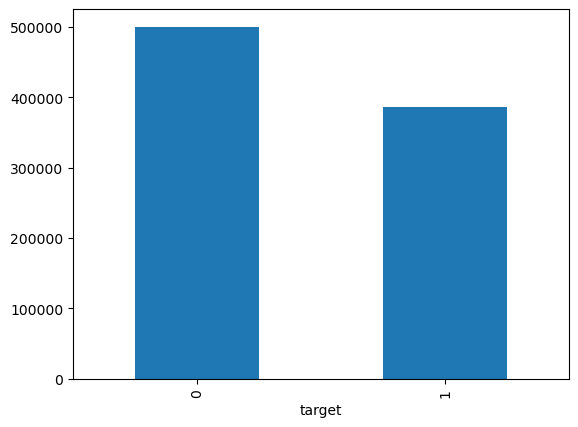

In [16]:
# Target column distribution
df_filtered[label].value_counts().plot(kind='bar')
plt.show()

# Create a signature column based on price movement
df_filtered['signature'] = (df_filtered['close'] > df_filtered['open']).astype(int)



In [ ]:
# Train the model with medium quality preset
# This will automatically save models to a timestamped directory
predictor = TabularPredictor(label=label).fit(
    df_filtered,
    presets='medium',  # Using medium preset as default
    verbosity=2  # Standard logging level
)

No path specified. Models will be saved in: "AutogluonModels\ag-20250406_065735"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.9
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.17763
CPU Count:          40
Memory Avail:       325.80 GB / 383.91 GB (84.9%)
Disk Space Avail:   566.11 GB / 1787.27 GB (31.7%)
No presets specified! To achieve strong results with AutoGluon, it is recommended to use the available presets. Defaulting to `'medium'`...
	Recommended Presets (For more details refer to https://auto.gluon.ai/stable/tutorials/tabular/tabular-essentials.html#presets):
	presets='experimental' : New in v1.2: Pre-trained foundation model + parallel fits. The absolute best accuracy without consideration for inference speed. Does not support GPU.
	presets='best'         : Maximize accuracy. Recommended for most users. Use in competitions and benchmarks.
	presets='high'     

In [ ]:
# Split the data into train and test sets
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(df_filtered, test_size=0.2, random_state=42)

# Make predictions on the test data
y_pred = predictor.predict(test_data.drop(columns=[label]))
y_pred.head()


In [ ]:
predictor.evaluate(test_data, silent=True)